<a href="https://colab.research.google.com/github/Shahid1993/pytorch-notebooks/blob/master/02_Transfer_Learning_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Deep Learning for Everyone: Master the Powerful Art of Transfer Learning using PyTorch](https://www.analyticsvidhya.com/blog/2019/10/how-to-master-transfer-learning-using-pytorch/?utm_source=blog&utm_medium=introduction-to-pytorch-from-scratch)

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# importing the libraries
import pandas as pd
import numpy as np
from tqdm import tqdm

# for reading and displaying images
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

# for creating the validation set
from sklearn.model_selection import train_test_split

# for evaluating model accuracy
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

# torch-vision for pre-trained models
from torchvision import models

# Loading dataset

In [0]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/ML/data/emergency_vs_non-emergency_dataset.zip","r") as zip_ref:
    zip_ref.extractall("/content/drive/My Drive/ML/data")

In [5]:
train = pd.read_csv("/content/drive/My Drive/ML/data/emergency_vs_non-emergency_dataset/emergency_train.csv")
train.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


In [6]:
# loading training images

train_img = []
for img_name in tqdm(train['image_names']):
  img_path = '/content/drive/My Drive/ML/data/emergency_vs_non-emergency_dataset/images/' + img_name
  img = imread(img_path)
  # normalizing the pixel values
  img = img / 255
  # resizing the image to (224, 224, 3)
  img = resize(img, output_shape=(224, 224, 3), mode='constant', anti_aliasing=True)
  # converting the type of pixel to float32
  img = img.astype('float32')

  # appending the image to the list
  train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)
train_x.shape
    


100%|██████████| 1646/1646 [00:20<00:00, 79.54it/s]


(1646, 224, 224, 3)

It is an Emergency Vehicle...


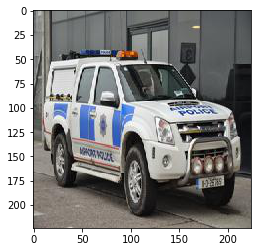

In [7]:
# Exploring the data

index = 10
plt.imshow(train_x[index])
if(train['emergency_or_not'][index] == 1):
  print('It is an Emergency Vehicle...')
else:
  print('It is a Non-Emergency Vehicle...')

In [0]:
# defining the target
train_y = train['emergency_or_not'].values

### Creating a validation Set

In [9]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=13, stratify=train_y)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((1481, 224, 224, 3), (1481,)), ((165, 224, 224, 3), (165,)))

### Converting dataset to torch format

In [10]:
# converting training images to torch format
train_x = train_x.reshape(1481, 3, 224, 224)
train_x = torch.from_numpy(train_x)

# converting the target to torch format
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([1481, 3, 224, 224]), torch.Size([1481]))

In [11]:
# converting validation images into torch format
val_x = val_x.reshape(165, 3, 224, 224)
val_x = torch.from_numpy(val_x)

# converting the target to torch format
val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([165, 3, 224, 224]), torch.Size([165]))

# Solving the Challenge using CNN

### Defining the model architecture

In [0]:
class Net(Module):
  def __init__(self):
    super(Net, self).__init__()

    self.cnn_layers = Sequential(
        # Defining a Conv2D layer
        Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
        BatchNorm2d(4),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2, stride=2),

        # Defining another 2D Convolutional Layer
        Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
        BatchNorm2d(8),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2, stride=2)
    )

    self.linear_layers = Sequential(
        Linear(8 * 56 * 56, 2)
    )

  # Defining the forward pass
  def forward(self, x):
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)
    return x

In [13]:
# defining the model
model = Net()

# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0001)

# defining the loss function
criterion = CrossEntropyLoss()

# checking if gpu is available
if torch.cuda.is_available():
  model = model.cuda()
  criterion = criterion.cuda()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=25088, out_features=2, bias=True)
  )
)


In [14]:
# batch size of the model
batch_size = 128

# no. of epochs to train the model
n_epochs = 15

for epoch in range(1, n_epochs+1):

  # keep track of training and validation loss
  train_loss = 0.0

  permutation = torch.randperm(train_x.size()[0])

  training_loss = []

  for i in tqdm(range(0, train_x.size()[0], batch_size)):

    indices = permutation[i:i+batch_size]
    batch_x, batch_y = train_x[indices], train_y[indices]

    if torch.cuda.is_available():
      batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    optimizer.zero_grad()

    # in case you wanted a semi-full example
    outputs = model(batch_x)
    loss = criterion(outputs, batch_y)

    training_loss.append(loss.item())
    loss.backward()
    optimizer.step()

  training_loss = np.average(training_loss)
  print('Epoch: \t', epoch, '\t Training Loss: \t', training_loss)

 17%|█▋        | 2/12 [00:00<00:00, 15.52it/s]

Epoch: 	 1 	 Training Loss: 	 0.8739065527915955


 17%|█▋        | 2/12 [00:00<00:00, 15.48it/s]

Epoch: 	 2 	 Training Loss: 	 0.6826314876476923


 17%|█▋        | 2/12 [00:00<00:00, 15.27it/s]

Epoch: 	 3 	 Training Loss: 	 0.6196133097012838


 17%|█▋        | 2/12 [00:00<00:00, 15.51it/s]

Epoch: 	 4 	 Training Loss: 	 0.5767600983381271


 17%|█▋        | 2/12 [00:00<00:00, 15.79it/s]

Epoch: 	 5 	 Training Loss: 	 0.5450718154509863


 17%|█▋        | 2/12 [00:00<00:00, 15.67it/s]

Epoch: 	 6 	 Training Loss: 	 0.5235856299599012


 17%|█▋        | 2/12 [00:00<00:00, 15.32it/s]

Epoch: 	 7 	 Training Loss: 	 0.5030707741777102


 17%|█▋        | 2/12 [00:00<00:00, 15.21it/s]

Epoch: 	 8 	 Training Loss: 	 0.472393440703551


 17%|█▋        | 2/12 [00:00<00:00, 15.70it/s]

Epoch: 	 9 	 Training Loss: 	 0.46101384858290356


 17%|█▋        | 2/12 [00:00<00:00, 15.34it/s]

Epoch: 	 10 	 Training Loss: 	 0.44815683116515476


 17%|█▋        | 2/12 [00:00<00:00, 15.65it/s]

Epoch: 	 11 	 Training Loss: 	 0.41871164242426556


 17%|█▋        | 2/12 [00:00<00:00, 15.44it/s]

Epoch: 	 12 	 Training Loss: 	 0.3980668957034747


 17%|█▋        | 2/12 [00:00<00:00, 15.80it/s]

Epoch: 	 13 	 Training Loss: 	 0.3936941747864087


 17%|█▋        | 2/12 [00:00<00:00, 15.09it/s]

Epoch: 	 14 	 Training Loss: 	 0.3732961018880208


100%|██████████| 12/12 [00:00<00:00, 13.57it/s]

Epoch: 	 15 	 Training Loss: 	 0.3525199194749196


# Checking Training and validation accuracies

In [15]:
# prediction for training set
prediction = []
target = []
permutation = torch.randperm(train_x.size()[0])
for i in tqdm(range(0,train_x.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = train_x[indices], train_y[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x)

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction.append(predictions)
    target.append(batch_y)
    
# training accuracy
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))
    
print('training accuracy: \t', np.average(accuracy))

100%|██████████| 12/12 [00:00<00:00, 18.28it/s]


training accuracy: 	 0.8803510273972602


In [16]:
# prediction for validation set
prediction_val = []
target_val = []

permutation = torch.randperm(val_x.size()[0])

for i in tqdm(range(0, val_x.size()[0], batch_size)):
  indices = permutation[i:i+batch_size]

  batch_x, batch_y = val_x[indices], val_y[indices]

  if torch.cuda.is_available():
    batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

  with torch.no_grad():
    output = model(batch_x)

  softmax = torch.exp(output).cpu()
  prob = list(softmax.numpy())
  predictions = np.argmax(prob, axis=1)
  prediction_val.append(predictions)
  target_val.append(batch_y)

# validation accuracy
accuracy_val = []
for i in range(len(prediction_val)):
  accuracy_val.append(accuracy_score(target_val[i].cpu(), prediction_val[i]))

print('Valiation accuracy: \t', np.average(accuracy_val))

100%|██████████| 2/2 [00:00<00:00, 25.76it/s]

Valiation accuracy: 	 0.6374577702702703


# Solving the Challenge using Transfer Learning

We will be using the VGG16 pre-trained model trained on the ImageNet dataset. Let’s look at the steps we will be following to train the model using transfer learning:

1. First, we will load the weights of the pre-trained model – VGG16 in our case
2. Then we will fine tune the model as per the problem at hand
3. Next, we will use these pre-trained weights and extract features for our images
4. Finally, we will train the fine tuned model using the extracted features

### Load model weights

In [17]:
# loading the pre-trained models
model = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:09<00:00, 57.2MB/s]


### Freeze model weights

In [0]:
# Freeze model weights
for param in model.parameters():
  param.requires_grad = False

### Update the final layer (classification layer) as per our problem - 2 classes instead of 1000 classes of VGG16

In [0]:
# Add on classifier
model.classifier[6] = Sequential(Linear(4096, 2))

for param in model.classifier[6].parameters():
  param.requires_grad = True

In [0]:
# Checking if GPU is available
if torch.cuda.is_available():
  model = model.cuda()

### Extracting features for training and validation images

In [21]:
# batch size
batch_size = 128

# extracting features for train_data
data_x = []
label_x = []

inputs, labels = train_x, train_y

for i in tqdm(range(int(train_x.shape[0] / batch_size)+1)):
  input_data = inputs[i*batch_size:(i+1)*batch_size]
  label_data = labels[i*batch_size:(i+1)*batch_size]

  input_data, label_data = Variable(input_data.cuda()), Variable(label_data.cuda())

  x = model.features(input_data)
  data_x.extend(x.data.cpu().numpy())
  label_x.extend(label_data.data.cpu().numpy())

  

100%|██████████| 12/12 [00:07<00:00,  1.77it/s]


In [22]:
# extracting features for validation data

data_y = []
label_y = []

inputs, labels = val_x, val_y

for i in tqdm(range(int(val_x.shape[0] / batch_size) + 1)):
  input_data = inputs[i*batch_size:(i+1)*batch_size]
  label_data = labels[i*batch_size:(i+1)*batch_size]

  input_data, label_data = Variable(input_data.cuda()), Variable(label_data.cuda())

  x = model.features(input_data)
  data_y.extend(x.data.cpu().numpy())
  label_y.extend(label_data.data.cpu().numpy())


100%|██████████| 2/2 [00:00<00:00,  1.78it/s]


In [0]:
# converting the features into torch format
x_train = torch.from_numpy(np.array(data_x))
x_train = x_train.view(x_train.size(0), -1)
y_train = torch.from_numpy(np.array(label_x))

x_val = torch.from_numpy(np.array(data_y))
x_val = x_val.view(x_val.size(0), -1)
y_val = torch.from_numpy(np.array(label_y))

### Define Optimizer and loss function for our model

In [0]:
import torch.optim as optim

# specify loss function
criterion = CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.0005)

### Training model

In [25]:
# batch size
batch_size = 128

# number of epochs to train the model
n_epochs = 30

for epoch in tqdm(range(1, n_epochs+1)):

    # keep track of training and validation loss
    train_loss = 0.0
        
    permutation = torch.randperm(x_train.size()[0])

    training_loss = []
    for i in range(0,x_train.size()[0], batch_size):

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        optimizer.zero_grad()
        # in case you wanted a semi-full example
        outputs = model.classifier(batch_x)
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)

  7%|▋         | 2/30 [00:00<00:05,  4.86it/s]

epoch: 	 1 	 training loss: 	 0.5898649245500565
epoch: 	 2 	 training loss: 	 0.4976205031077067


 13%|█▎        | 4/30 [00:00<00:04,  5.48it/s]

epoch: 	 3 	 training loss: 	 0.4766268655657768
epoch: 	 4 	 training loss: 	 0.45136770854393643


 20%|██        | 6/30 [00:01<00:04,  5.97it/s]

epoch: 	 5 	 training loss: 	 0.43965677668650943
epoch: 	 6 	 training loss: 	 0.4265967284639676


 27%|██▋       | 8/30 [00:01<00:03,  6.25it/s]

epoch: 	 7 	 training loss: 	 0.4247075269619624
epoch: 	 8 	 training loss: 	 0.41333430012067157


 33%|███▎      | 10/30 [00:01<00:03,  6.36it/s]

epoch: 	 9 	 training loss: 	 0.4009480228026708
epoch: 	 10 	 training loss: 	 0.40423870583375293


 40%|████      | 12/30 [00:01<00:02,  6.38it/s]

epoch: 	 11 	 training loss: 	 0.40640713026126224
epoch: 	 12 	 training loss: 	 0.3881566921869914


 47%|████▋     | 14/30 [00:02<00:02,  6.45it/s]

epoch: 	 13 	 training loss: 	 0.38211048394441605
epoch: 	 14 	 training loss: 	 0.38583119710286456


 53%|█████▎    | 16/30 [00:02<00:02,  6.45it/s]

epoch: 	 15 	 training loss: 	 0.3752950007716815
epoch: 	 16 	 training loss: 	 0.3737300584713618


 60%|██████    | 18/30 [00:02<00:01,  6.42it/s]

epoch: 	 17 	 training loss: 	 0.37405649572610855
epoch: 	 18 	 training loss: 	 0.3751760348677635


 67%|██████▋   | 20/30 [00:03<00:01,  6.49it/s]

epoch: 	 19 	 training loss: 	 0.3789556349317233
epoch: 	 20 	 training loss: 	 0.3705957258741061


 73%|███████▎  | 22/30 [00:03<00:01,  6.50it/s]

epoch: 	 21 	 training loss: 	 0.36488648504018784
epoch: 	 22 	 training loss: 	 0.3707384417454402


 80%|████████  | 24/30 [00:03<00:00,  6.47it/s]

epoch: 	 23 	 training loss: 	 0.34721732636292774
epoch: 	 24 	 training loss: 	 0.3597051997979482


 87%|████████▋ | 26/30 [00:04<00:00,  6.52it/s]

epoch: 	 25 	 training loss: 	 0.3473519558707873
epoch: 	 26 	 training loss: 	 0.35548730939626694


 93%|█████████▎| 28/30 [00:04<00:00,  6.54it/s]

epoch: 	 27 	 training loss: 	 0.3471622144182523
epoch: 	 28 	 training loss: 	 0.3505983476837476


100%|██████████| 30/30 [00:04<00:00,  6.55it/s]

epoch: 	 29 	 training loss: 	 0.34715692947308224
epoch: 	 30 	 training loss: 	 0.3455287615458171


In [26]:
# prediction for training set
prediction = []
target = []
permutation = torch.randperm(x_train.size()[0])
for i in tqdm(range(0,x_train.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = x_train[indices], y_train[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model.classifier(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction.append(predictions)
    target.append(batch_y)
    
# training accuracy
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))
    
print('training accuracy: \t', np.average(accuracy))

100%|██████████| 12/12 [00:00<00:00, 54.46it/s]

training accuracy: 	 0.8544698915525114


In [27]:
# prediction for validation set
prediction_val = []
target_val = []
permutation = torch.randperm(x_val.size()[0])
for i in tqdm(range(0,x_val.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = x_val[indices], y_val[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model.classifier(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction_val.append(predictions)
    target_val.append(batch_y)
    
# validation accuracy
accuracy_val = []
for i in range(len(prediction_val)):
    accuracy_val.append(accuracy_score(target_val[i].cpu(),prediction_val[i]))
    
print('validation accuracy: \t', np.average(accuracy_val))

100%|██████████| 2/2 [00:00<00:00, 81.48it/s]

validation accuracy: 	 0.8578969594594594
